In [6]:
import torch
from torch.nn import BCEWithLogitsLoss
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
#from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import KMeans
import sklearn
import pandas as pd
import numpy as np
import platform
import collections
import gc
gc.set_threshold(100, 10, 10)
import re
from matplotlib import pyplot as plt

print(platform.python_implementation())
%matplotlib inline

CPython


In [7]:
profiles = pd.read_csv('profiles.csv')
print(len(profiles['smokes']))
scaler = StandardScaler()
print(profiles.head())
print(profiles.info())
print(profiles.columns)

59946
   age       body_type               diet    drinks      drugs  \
0   22  a little extra  strictly anything  socially      never   
1   35         average       mostly other     often  sometimes   
2   38            thin           anything  socially        NaN   
3   23            thin         vegetarian  socially        NaN   
4   29        athletic                NaN  socially      never   

                           education  \
0      working on college/university   
1              working on space camp   
2     graduated from masters program   
3      working on college/university   
4  graduated from college/university   

                                              essay0  \
0  about me:<br />\n<br />\ni would love to think...   
1  i am a chef: this is what that means.<br />\n1...   
2  i'm not ashamed of much, but writing public te...   
3          i work in a library and go to school. . .   
4  hey how's it going? currently vague on the pro...   

                   

In [8]:
inc_feat= ['drinks', 'drugs']
print(profiles['education'])
for i in profiles['education']:
    undergrads= ['working on college/university','graduated from two-year college' ,'graduated from high school','working on two-year college','dropped out of college/university ', 'dropped out of space camp', 'working on space camp', 'working on law school', 'two-year college']
    postgrads = ['graduated from college/university', 'graduated from masters program', 'working on masters program', 'graduated from ph.d program', 'graduated from law school', 'working on ph.d program', 'college/university', 'graduated from space camp', 'graduated from med school','dropped out of masters program','masters program', 'dropped out of ph.d program', 'space camp', 'ph.d program', 'law school', 'dropped out of law school', 'dropped out of med school', 'med school']
    other = ['high school', 'dropped out of two-year college']
    if i in other:
        profiles['education'] = profiles['education'].replace({
            i:0
        })
    elif i in undergrads:
        profiles['education']= profiles['education'].replace({
            i:1
        })
    else:
        profiles['education']= profiles['education'].replace({
            i:2
        })
    
print(profiles['education'])

0            working on college/university
1                    working on space camp
2           graduated from masters program
3            working on college/university
4        graduated from college/university
                       ...                
59941    graduated from college/university
59942        working on college/university
59943       graduated from masters program
59944        working on college/university
59945       graduated from masters program
Name: education, Length: 59946, dtype: object
0        1
1        1
2        2
3        1
4        2
        ..
59941    2
59942    1
59943    2
59944    1
59945    2
Name: education, Length: 59946, dtype: int64


From these counts, it is clear that OKCupid has a large user base within graduated university students. This includes a significant number of people that continued their education and graduated from a masters degree program. This suggests a possible connection between education level and usage of OKCupid

In [9]:
#Gathering all profiles 'education' details
#education = profiles['education']
#print(education.values)
#edu_labs= [profiles['education'].unique() for profiles['education'] in profiles['education']]

profiles['grad_type']=[0 if i=='graduated from college/university' or i == 'graduated from masters program' else 1 for i in profiles['education']]

print(profiles['grad_type'])

0        1
1        1
2        1
3        1
4        1
        ..
59941    1
59942    1
59943    1
59944    1
59945    1
Name: grad_type, Length: 59946, dtype: int64


In [10]:
drugs = profiles['drugs']
drugs.value_counts()



drugs
never        37724
sometimes     7732
often          410
Name: count, dtype: int64

This shows that the vast majority of profiles say they do not take drugs. This may be due to the profile owners not wanting to make it public that they use recreational drugs.

In [11]:

profiles['drugs'] = profiles['drugs'].replace({
    'never':0,
    'sometimes':1,
    'often':2,
})
profiles['drugs'] = profiles['drugs'].fillna(0)

In [12]:
print(profiles['drugs'].head)


<bound method NDFrame.head of 0        0.0
1        1.0
2        0.0
3        0.0
4        0.0
        ... 
59941    0.0
59942    1.0
59943    0.0
59944    2.0
59945    0.0
Name: drugs, Length: 59946, dtype: float64>


In [36]:
profiles['income'] = profiles['income'].fillna(0)

In [37]:
smokes = profiles[['smokes']]
smokes.value_counts()

smokes
0.0       49408
1.0        3787
2.0        3040
4.0        2231
3.0        1480
Name: count, dtype: int64

In [38]:
profiles['smokes'] = profiles['smokes'].replace({
    'no':0,
    'sometimes':1,
    'when drinking':2,
    'yes':4,
    'trying to quit':3
})
profiles['smokes'] = profiles['smokes'].fillna(0)

In [39]:
print(profiles['smokes'])

0        1.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
59941    0.0
59942    0.0
59943    0.0
59944    3.0
59945    1.0
Name: smokes, Length: 59946, dtype: float64


In [40]:
#drinks = profiles['drinks']

profiles['drinks'] = profiles['drinks'].replace({
    'not at all':0,
    'rarely':1,
    'socially':2,
    'often':3,
    'very often':4,
    'desperately':5
})
profiles['drinks'] = profiles['drinks'].fillna(0)
print(profiles['drinks'].value_counts)

<bound method IndexOpsMixin.value_counts of 0        2.0
1        3.0
2        2.0
3        2.0
4        2.0
        ... 
59941    2.0
59942    3.0
59943    0.0
59944    2.0
59945    2.0
Name: drinks, Length: 59946, dtype: float64>


This would suggest that most OkCupid users are very likely to drink if they are in a social setting, but not necessarily alone.

In [41]:
print(profiles['age'].info())
for i in profiles['age']:
    #for the minimum age
    if i == 18:
        profiles['age'] = profiles['age'].replace({
            i:0
        })
    # 19 to 26
    elif i > 18 and i < 27:
        profiles['age'] = profiles['age'].replace({
            i:1
        })
    # 27 to 33
    elif i>26 and i<34:
        profiles['age'] = profiles['age'].replace({
            i:2
        })
    #34 to 4o
    elif i>33 and i<41:
        profiles['age'] = profiles['age'].replace({
            i:3
        })
    # 41 to 47
    elif i > 40 and i< 48:
        profiles['age'] = profiles['age'].replace({
            i:4
        })
    #48 to 54
    elif i > 47 and i < 55:
        profiles['age'] = profiles['age'].replace({
            i:5
        })
    #55 to 61
    elif i > 54 and i < 62:
        profiles['age'] = profiles['age'].replace({
            i:6
        })
    #62 onwards~
    elif i > 61:
        profiles['age'] = profiles['age'].replace({
            i:7
        })
    
profiles['age'].fillna(0)
print(profiles['age'])

<class 'pandas.core.series.Series'>
RangeIndex: 59946 entries, 0 to 59945
Series name: age
Non-Null Count  Dtype
--------------  -----
59946 non-null  int64
dtypes: int64(1)
memory usage: 468.5 KB
None
0        1
1        3
2        3
3        1
4        2
        ..
59941    6
59942    1
59943    4
59944    2
59945    3
Name: age, Length: 59946, dtype: int64


In [42]:
model = nn.Sequential(
    nn.Linear(41962,20981),
    nn.ReLU(),
    nn.Linear(20981,10490),
    nn.ReLU(),
    nn.Linear(10490,5245),
    nn.ReLU(),
    nn.Linear(5245,2622),
    nn.ReLU(),
    nn.Linear(2622, 1311),
    nn.ReLU(),
    nn.Linear(1311, 655),
    nn.ReLU(),
    nn.Linear(655, 1)
)

print(profiles['smokes'].values.astype(np.float64))

[1. 0. 0. ... 0. 3. 1.]


In [52]:
torch.manual_seed(13)
labels=['education']
X= torch.tensor(profiles[inc_feat].values.astype(np.float64), dtype= torch.float64)
y= torch.tensor(profiles[labels].values.astype(np.float64), dtype= torch.float64).reshape(-1, 1)

#profiles = profiles.drop_duplicates(subset = inc_feat)
#print(len(profiles))
#print(len(X))
#print(len(X),len(y))
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y)

print(X_scaled[:])
print(y_scaled)

[[ 0.23631166 -0.38686251 -0.20580558  0.63390421]
 [ 1.48013806  2.32488448  0.61602078 -0.4010957 ]
 [ 0.23631166 -0.38686251 -0.20580558 -0.4010957 ]
 ...
 [-2.25134114 -0.38686251  0.82147481 -0.4010957 ]
 [ 0.23631166  5.03663147 -0.20580558  2.70390405]
 [ 0.23631166 -0.38686251 -0.20580558  0.63390421]]
[[-1.96361873]
 [-1.96361873]
 [ 0.48014245]
 ...
 [ 0.48014245]
 [-1.96361873]
 [ 0.48014245]]


[[-0.08239029 -0.38686251 -0.09088048 -0.25752453]
 [ 0.38422615  0.70516533 10.06690586  0.33179613]
 [ 0.38769552  1.81959241 -0.07508722  1.23972907]]


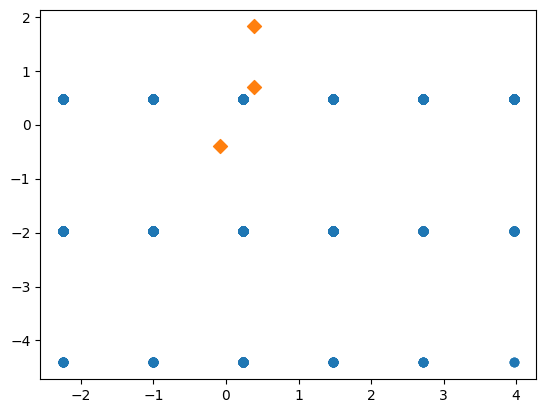

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.30, random_state= 13)
loss= nn.BCEWithLogitsLoss
#optimizer = optim

score_lst= []
i=[]

knclass = KMeans(n_clusters=3, random_state=13, n_init=10)
knclass.fit(X_train, y_train)
labels = knclass.predict(X_train)
centroids = knclass.cluster_centers_
centroids_X = centroids[:,0]
centroids_y = centroids[:,1]
print(centroids)
plt.scatter(X_train[:,0], y_train)
#plt.plot(X_train[:,0],y_train)
plt.scatter(centroids_X, centroids_y, marker='D', s=50)
plt.show()

In [62]:
print(knclass.score(X_test, y_test))
#print(knclass.predict_proba(X_test))

-37267.35321474306


In [74]:
clf = MLPClassifier(random_state=13, max_iter = 3000, solver='adam', learning_rate_init=0.001).fit(X_train, y_train)

for epoch in range(1000):
    predictions = clf.predict(X_test)
    BCEll = loss(X_test, predictions) # compute loss
    BCEll.backward() # compute gradients
    optimizer.step()
    optimizer.zero_grad()
    if epoch % 100 == 0:
        print(f'Epoch is {epoch} loss is {MSE}')

C:\Users\Vapou\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


ValueError: Unknown label type: (array([0.48014245, 0.48014245, 0.48014245, ..., 0.48014245, 0.48014245,
       0.48014245]),)